# Milestone 2 - Independent Project
Version: Jun-2019

## Author - Kumaran Singaram

## Instructions

1. Generate a clear problem statement and provide the location for the dataset you use.
2. Provide a clear solution to the problem for a non-technical audience.
3. Visually explore the data to generate insight and include summary statistics.
8. Use professional coding standards and techniques including:

    - explanatory markdown text
    - proper code comments
    - functions to minimize redundant code
    - minimize hard-coded variables

## Problem

In this dataset, we will be analyzing pokemon across 6 generations, including legendary pokemon and those that have more than a single type. Pokemon is a game that has spanned decades and thus, has hundreds of different pokemon created for different generations of kids to enjoy. Within these generations, there are also legendary pokemon which are extremely difficult to catch and often times stronger than the average pokemon.

To explore this dataset, we will use a variety of summary statistics using classical, bootstrap, and Bayesian methods. We will test for normality within specific features and compare features to check signficance in population means.

The data set consists of 721 pokemon. The full set of variables are listed below:

- #: ID for each Pokemon
- Name: Name of each Pokemon
- Type 1: Each Pokemon has a type
- Type 2: Some Pokemon have dual types
- Total: Sum of all stats
- HP: Hit Points (Health)
- Attack: Normal Attacks
- Defense: Normal Defense
- SP Atk: Special Attack
- SP Def: Special Defense
- Speed: Determines Pokemon that attacks first
- Generation: Generation from which the Pokemon comes from
- Legendary: A unique (only one in the game) Pokemon, often very powerful

In [179]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import scipy
import statsmodels
import statsmodels.stats as st
import statsmodels.api as sm
import statsmodels.stats.power as sp
import statsmodels.stats.weightstats as ws
import scipy.stats as ss
import random

In [180]:
# Load necessary libraries

pokemon = pd.read_csv('data/pokemon.csv')

pokemon.head()

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False
3,3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,False
4,4,Charmander,Fire,NaN,309,39,52,43,60,50,65,1,False


In [181]:
#check data types

pokemon.dtypes

#              int64
Name          object
Type 1        object
Type 2        object
Total          int64
HP             int64
Attack         int64
Defense        int64
Sp. Atk        int64
Sp. Def        int64
Speed          int64
Generation     int64
Legendary       bool
dtype: object

In [182]:
#summarize numeric attributes

pokemon['Generation'] = pokemon['Generation'].astype('object')

pokemon.describe()

,#,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed
count,800.000000,800.00000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000
mean,362.813750,435.10250,69.258750,79.001250,73.842500,72.820000,71.902500,68.277500
std,208.343798,119.96304,25.534669,32.457366,31.183501,32.722294,27.828916,29.060474
min,1.000000,180.00000,1.000000,5.000000,5.000000,10.000000,20.000000,5.000000
25%,184.750000,330.00000,50.000000,55.000000,50.000000,49.750000,50.000000,45.000000
50%,364.500000,450.00000,65.000000,75.000000,70.000000,65.000000,70.000000,65.000000
75%,539.250000,515.00000,80.000000,100.000000,90.000000,95.000000,90.000000,90.000000
max,721.000000,780.00000,255.000000,190.000000,230.000000,194.000000,230.000000,180.000000


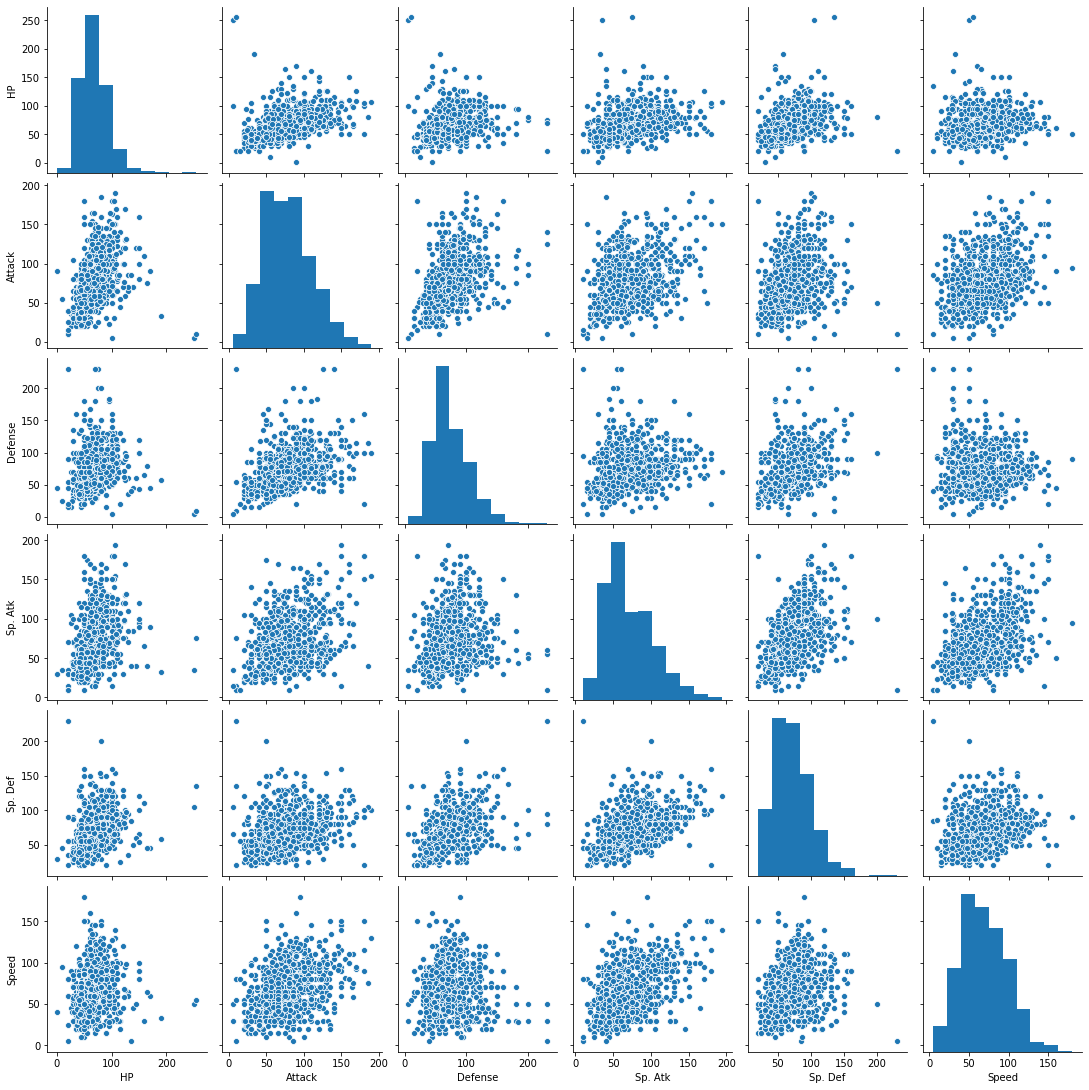

In [183]:
#explore feature distributions

sns.pairplot(pokemon, vars = ['HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed']);

The above pairplot is a comprehensive view of the distributions within the numeric attributes of the data set. We can use the histograms to check distributions and the scatterplots to understand correlations.

From what we can see, all the numeric attributes have more or less normal distributions. Some are skewed slightly to the left, such as Sp.Def, HP, and others. But for the most part, we seem to be dealing with normal distributions. We will use the bootstrap method later to test normality on the 'Total' feature to confirm this.

### Exploratory Data Analysis

In [184]:
#use crosstab table to understand possible type advantages

green = sns.light_palette("green", as_cmap=True)
pd.crosstab(index = pokemon['Type 1'], columns = pokemon['Generation'], normalize = 'index').style.background_gradient(cmap=green)

Generation,1,2,3,4,5,6
Type 1,,,,,,
Bug,0.202899,0.173913,0.173913,0.144928,0.260870,0.043478
Dark,0.000000,0.193548,0.193548,0.096774,0.419355,0.096774
Dragon,0.093750,0.000000,0.375000,0.125000,0.281250,0.125000
Electric,0.204545,0.159091,0.113636,0.272727,0.181818,0.068182
Fairy,0.117647,0.294118,0.000000,0.058824,0.000000,0.529412
Fighting,0.259259,0.074074,0.185185,0.111111,0.259259,0.111111
Fire,0.269231,0.153846,0.153846,0.096154,0.173077,0.153846
Flying,0.000000,0.000000,0.000000,0.000000,0.500000,0.500000
Ghost,0.125000,0.031250,0.156250,0.218750,0.156250,0.312500


The crosstab table above displays the distribution of Pokemon primary types across generation. A couple items that standout is the lack of 'Flying' type Pokemon in the first four generations. From my knowledge, this is because 'Flying' is typically is a secondary type, rather than primary. 

From this table, we can also gauge that certain types have stable distributions across all generations. Rock, Grass, and Pyschic are distributed more evenly throughout.

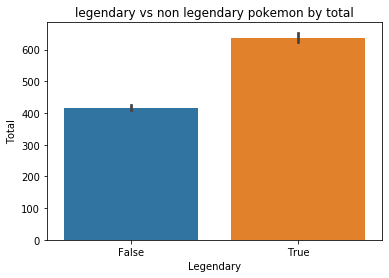

In [185]:
#visualize bar plot of difference between quality of legendary vs non legendary pokemon

ax = sns.barplot(x = 'Legendary', y = 'Total', data = pokemon)
ax.set_title('legendary vs non legendary pokemon by total');

Another question that is important is how much stronger legendary pokemon are than non legendary pokemon. From the barplot above, it seems that on average, Legendary pokemon have about 200 more total attribute points than non legendary pokemon. This is quite a significant difference.

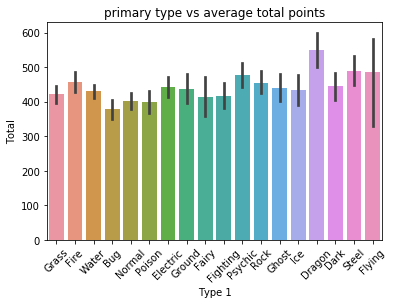

In [186]:
#visualize bar plot of primary types vs average totals

type_total = sns.barplot(x = 'Type 1', y = 'Total', data = pokemon)
type_total.set_xticklabels(type_total.get_xticklabels(), rotation = 45)
type_total.set_title('primary type vs average total points');

Here is a similar barplot focused instead, on primary types. From the chart, we can see that Dragon pokemon are the strongest overall on average. Pyschic and Steel fall next in line with Flying also in the mix, but note the variance in the results. This is due to what we noted above regarding Flying. Not many pokemon have it as a primary type.

In [187]:
#create crosstab tables to visualize counts

purple = sns.light_palette("purple", as_cmap=True)
pd.crosstab(index = pokemon['Generation'], columns = pokemon['Legendary']).style.background_gradient(cmap=purple)

Legendary,False,True
Generation,,
1,160,6
2,101,5
3,142,18
4,108,13
5,150,15
6,74,8


To get a more granular look at legendary pokemon, we can visualize them here by generation. It looks like the makers back end loaded the legendary pokemon. Generation 3 surprisingly had ~3x the number of legendaries as 1 and 2.

In [188]:
blue = sns.light_palette("blue", as_cmap=True)
pd.crosstab(index = pokemon['Type 1'], 
                     columns = pokemon['Legendary']).style.background_gradient(cmap=blue)

Legendary,False,True
Type 1,,
Bug,69,0
Dark,29,2
Dragon,20,12
Electric,40,4
Fairy,16,1
Fighting,27,0
Fire,47,5
Flying,2,2
Ghost,30,2


Here, we can visualize legendary pokemon by type. It looks like legendary pokemon may play a large role in boosting the average totals for pyschic and dragon pokemon because these types seem to be overweight on legendary pokemon. No other type even has more than 5 legendary pokemon, while pyschic and dragon types have more than 10.

It's interesting to note that Poison, Fighting, and Bug Pokemon have 0 legendary pokemon.

In [189]:
#feature engineer two_types category as a binary variable

pokemon['two_types'] = (pokemon['Type 2'].isnull())*1
pokemon.head()

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary,two_types
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False,0
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False,0
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False,0
3,3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,False,0
4,4,Charmander,Fire,NaN,309,39,52,43,60,50,65,1,False,1


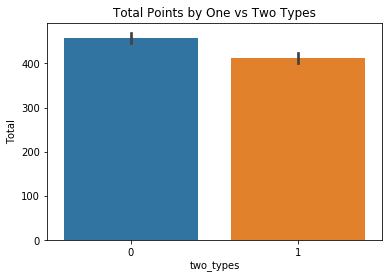

In [190]:
ax = sns.barplot(x = 'two_types', y = 'Total', data = pokemon)
ax.set_title('Total Points by One vs Two Types');

The intriguing question about this data set is regarding the pokemon that have a primary and secondary type vs the pokemon that have only a primary type. I thought it would be interesting the visualize the difference.

As I expected, the pokemon with two types do look to be stronger than those with just one type on average. We will be looking at this more to confirm whether there is in fact a significant difference.

In [191]:
#break total attribute into bins for heat map

num_bins = 15
pokemon['total-bin'] = pd.cut(pokemon['Total'], bins = num_bins, labels = range(num_bins))
pokemon[['Total', 'total-bin']].head()

,Total,total-bin
0,318,3
1,405,5
2,525,8
3,625,11
4,309,3


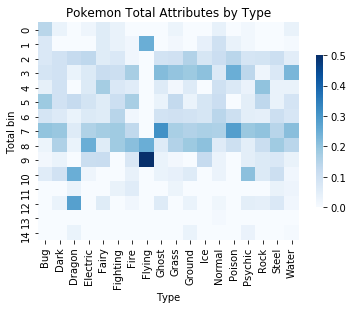

In [192]:
#create a heat map using the crosstab table

total_type = pd.crosstab(pokemon['total-bin'], pokemon['Type 1'], normalize = 'columns')
ax = sns.heatmap(total_type, cmap = 'Blues', square = True, cbar_kws = {'shrink': 0.7})
ax.set_xlabel('Type')
ax.set_ylabel('Total bin')
ax.set_title('Pokemon Total Attributes by Type');

Once again, there's heavy concentration in the flying type, but this is due to a light sample size. Additionally, Dragon, Ground, and Psychic seem to be the only types with a visibly non zero concentration of high totals. Ghost and Poison look to be the most 'average' Pokemon types.

### Bootstrapping

From the EDA above, it seems that an important aspect of this data set is centered around whether a pokemon has a secondary type. We can feature engineer new variables to analyze one type vs two type pokemon. I will be using bootstrap sampling after doing this to test for normality.

In [193]:
#create two new variables conditional on one vs two types
one_type = pokemon.loc[pokemon['two_types'] == 1, 'Total']
two_types = pokemon.loc[pokemon['two_types'] == 0, 'Total']

In [194]:
#bootstrap with replacement

sample_mean = []

for i in range(100):
    y = random.sample(one_type.tolist(), 20)
    avg = np.mean(y)
    
    
    sample_mean.append(avg)

In [195]:
#bootstrap with replacement for two type pokemon

sample_mean_two = []

for i in range(100):
    y = random.sample(two_types.tolist(), 20)
    avg = np.mean(y)
    
    
    sample_mean_two.append(avg)

In [196]:
#display summary statistics

bootstrap_mean = np.mean(sample_mean)
bootstrap_std = np.std(sample_mean)
bootstrap_mean_two = np.mean(sample_mean_two)
bootstrap_std_two = np.std(sample_mean_two)

In [197]:
print('One Type Bootstrap Mean: %.1f' % bootstrap_mean)
print('One Type Bootstrap Std: %.1f' % bootstrap_std)

One Type Bootstrap Mean: 413.4
One Type Bootstrap Std: 25.7


In [198]:
print('Two Type Bootstrap Mean: %.1f' % bootstrap_mean_two)
print('Two Type Bootstrap Std: %.1f' % bootstrap_std_two)

Two Type Bootstrap Mean: 455.4
Two Type Bootstrap Std: 25.5


From the bootstrap sample and summary statistics, it looks like the two type sample is almost 50 attribute points greater. Let's look at the distributions on top of each other to visualize the difference.

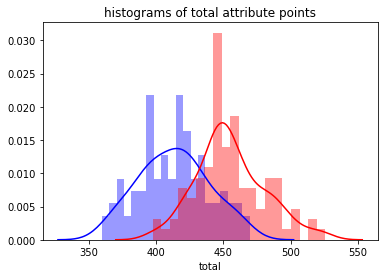

In [199]:
#plot the distribution of the two samples

plt.title('histograms of total attribute points')
sns.distplot(sample_mean, color = 'blue', bins = 20, kde = True)
sns.distplot(sample_mean_two, color = 'red', bins = 20, kde = True)
plt.xlabel('total');

There is some overlap between the distributions, but there is still a noticeably clear difference. Calculating their confidence intervals should help us understand the distributions better.

In [200]:
#identify confidence intervals

alpha = 0.95
half_width = scipy.stats.norm.ppf((1+alpha)/2, loc = bootstrap_mean, scale = bootstrap_std) - bootstrap_mean
print('Half Width - One Type: %.1f' % half_width)

ci_low = bootstrap_mean - half_width
ci_high = bootstrap_mean + half_width

print('CI Low - One Type: %.1f' % ci_low)
print('CI High - One Type: %.1f' % ci_high)

Half Width - One Type: 50.3
CI Low - One Type: 363.1
CI High - One Type: 463.7


In [201]:
alpha = 0.95
half_width_two = scipy.stats.norm.ppf((1+alpha)/2, 
                                      loc = bootstrap_mean_two, scale = bootstrap_std_two) - bootstrap_mean_two
print('Half Width - Two Type: %.1f' % half_width_two)

ci_low_two = bootstrap_mean_two - half_width_two
ci_high_two = bootstrap_mean_two + half_width_two

print('CI Low - Two Type: %.1f' % ci_low_two)
print('CI High - Two Type: %.1f' % ci_high_two)

Half Width - Two Type: 50.0
CI Low - Two Type: 405.4
CI High - Two Type: 505.3


The confidence intervals seem to tell us that the low end of the two type pokemon overlap into the one type pokemon. The two type pokemon also have a wider range of intervals, indicating a higher variation and less stability. We can now test for normality using the KS test.

In [202]:
#normalize the bootstrap samples

bootstrap_norm = (sample_mean - bootstrap_mean) / bootstrap_std
bootstrap_norm_two = (sample_mean_two - bootstrap_mean_two) / bootstrap_std_two

In [203]:
ss.kstest(bootstrap_norm, 'norm')

KstestResult(statistic=0.049920535766550034, pvalue=0.9644512050832245)

In [204]:
ss.kstest(bootstrap_norm_two, 'norm')

KstestResult(statistic=0.09156113716249181, pvalue=0.352021008162218)

In both cases, we must fail to reject the null hypothesis that the distributions are normal. The KS test confirms what we saw from the visualizations after bootstrapping sampling from the data set. Below is a chart visualizing the CDFs of the two data sets, showing fairly similar patterns.

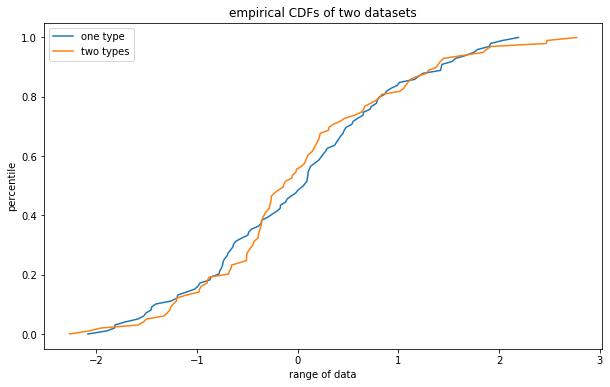

In [205]:
def plot_cums(dist1, dist2, labels = ['sample 1', 'sample 2']):
    plt.figure(figsize = (10, 6))
    p = np.arange(len(dist1)) / (len(dist1) - 1) # calculate the proportional values of samples

    data_sorted = np.sort(dist1) # sort the first data sample
    sns.lineplot(x = data_sorted, y = p)
    
    data_sorted = np.sort(dist2) # sort the seond data sample:
    sns.lineplot(x = data_sorted, y = p)

    plt.title('empirical CDFs of two datasets')
    plt.xlabel('range of data')
    plt.ylabel('percentile')
    plt.legend(labels = labels)

    return None

plot_cums(bootstrap_norm, bootstrap_norm_two, labels = ['one type', 'two types'])

### Two Sample independent t-test to Compare Pokemon Types

Before we conduct a t-test to test for signficance between the samples, we can start by plotting the distribution. If there is very strong overlap, it is unlikely we see significance.

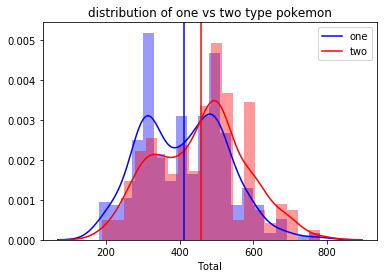

In [206]:
#plot histogram of the two distributions

sns.distplot(one_type, color = 'blue', bins = 20, kde = True)
sns.distplot(two_types, color = 'red', bins = 20, kde = True)
plt.title('distribution of one vs two type pokemon')
plt.axvline(one_type.mean(), 0, color = 'blue')
plt.axvline(two_types.mean(), 0, color = 'red')
plt.legend(labels = ['one', 'two']);

There seems to be strong overlap between the two samples. But to check if the difference of means between the two samples are significant, we must conduct a two-sided independent t-test.

In [207]:
#define the t test function
#use one type and two type pokemon as inputs

def t_test(a, b, alpha = 0.05, alternative = 'two-sided', type = 'independent'):

    diff = a.mean() - b.mean()
    if type == 'independent':
        res = ss.ttest_ind(a, b, equal_var = False)
    elif type == 'paired':
        assert(len(a) == len(b))
        res = ss.ttest_rel(a, b)
      
    means = ws.CompareMeans(ws.DescrStatsW(a), ws.DescrStatsW(b))
    confint = means.tconfint_diff(alpha = alpha, alternative = alternative, usevar = 'unequal') 
    degfree = means.dof_satt()

    index = ['deg_of_freedom', 'observed_difference', 't-statistic', 'p_value', 'low_95_CI', 'high_95_CI']
    return pd.Series([degfree, diff, res[0], res[1], confint[0], confint[1]], index = index)   
   

t_test(one_type, two_types)

deg_of_freedom         7.977329e+02
observed_difference   -4.461248e+01
t-statistic           -5.355678e+00
p_value                1.115706e-07
low_95_CI             -6.096366e+01
high_95_CI            -2.826129e+01
dtype: float64

It looks like the the p-value is very small and the confidence interval does not straddle 0, so we can safely reject the null hypothesis that the difference of means between the two samples is not significant.

### Bayesian Sampling

For Bayesian sampling, let's use a subset of 100 samples and calculate the mean.

Mean Total: 418.8


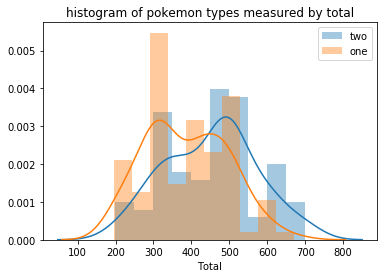

In [208]:
num_samples = 100
two = pokemon[pokemon.two_types == 0].sample(n = num_samples)
one = pokemon[pokemon.two_types == 1].sample(n = num_samples)

plt.title('histogram of pokemon types measured by total')
sns.distplot(two['Total'], label = 'two', bins = 10)
sns.distplot(one['Total'], label = 'one', bins = 10)
plt.xlabel('Total')
plt.legend();

mean = np.concatenate([two.Total, one.Total,]).mean()
print('Mean Total: %.1f' % mean)

To perform this analysis, we need to select a prior distribution and compute the likelihood. The function to calculate the posterior is below. Notice that the inputs require a prior and likelihood.

### Two Type Pokemon

In [209]:
num_samples = 100000
lower_q, upper_q = [.025, .975]

def plot_ci(p, post, num_samples, lower_q, upper_q, **kw):
    samples = np.random.choice(p, size = num_samples, replace = True, p = post)
    ci = np.percentile(samples, [lower_q*100, upper_q*100]) # compute the quantiles
    
    interval = upper_q - lower_q
    plt.title('Posterior density with %.3f credible interval' % interval)
    sns.lineplot(p, post, color = 'blue', **kw)
    plt.xlabel('Parameter value')
    plt.ylabel('Density')
    plt.axvline(x = ci[0], color = 'red')
    plt.axvline(x = ci[1], color = 'red')
    print('The {:0.3f} credible interval is {:0.3f} to {:0.3f}'.format(interval, lower_q, upper_q))

In [210]:
def posterior(prior, like):
    post = prior * like # compute the product of the probabilities
    return post / post.sum() # normalize the distribution to sum to unity

Mean = 451.140, Standard deviation = 118.232


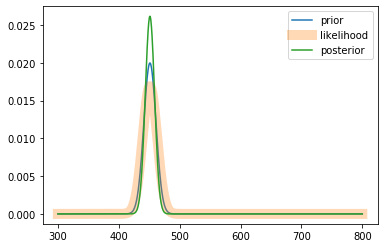

In [211]:
#calculate prior
#define a likelihood function
#compute the posterior using the coputed likelihood and prior

N = 1000
x = np.linspace(300, 800, num = N)
prior = scipy.stats.norm.pdf(x, loc = two['Total'].mean(), scale = 10)
prior = prior / prior.sum() # normalize

def likelihood(p, x): 
    x_var = np.var(x) # sigmasqr
    x_mean = np.mean(x)  # xbar
    print('Mean = %.3f, Standard deviation = %.3f' % (x_mean, x_var**0.5))
    n = len(x)
    l = np.exp((-1/(2*x_var)) * (sum((x - x_mean)**2) + n*(x_mean - p)**2))
    return l / l.sum()

likelihood = likelihood(x, two['Total'])
posterior = posterior(prior, likelihood)

sns.lineplot(x, prior, label = 'prior')
sns.lineplot(x, likelihood, label = 'likelihood', alpha = .3, linewidth = 10)
sns.lineplot(x, posterior, label = 'posterior')
plt.legend();

The mean of the posterior distribution looks to be around 450 with a high standard deviation for two type pokemon. Let's visualize the confidence intervals and then look at one type pokemon for comparison.

The 0.950 credible interval is 0.025 to 0.975


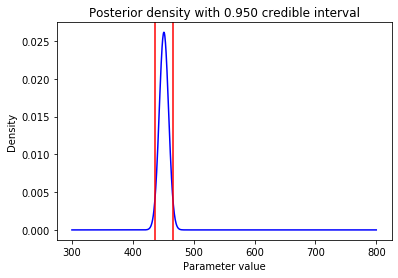

In [212]:
plot_ci(x, posterior, num_samples, lower_q, upper_q)

The confidence intervals are over 450 total attribute points, but under the 500 mark. Once we compare this to one type pokemon, we can make a conclusion on whether there is a signficant difference between the two samples.

### One Type Pokemon

In [213]:
def posterior(prior, like):
    post = prior * like # compute the product of the probabilities
    return post / post.sum() # normalize the distribution to sum to unity

Mean = 386.460, Standard deviation = 107.360


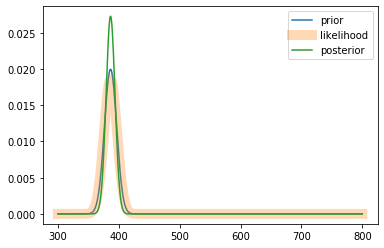

In [214]:
N_1 = 1000
x_1 = np.linspace(300, 800, num = N)
prior_1 = scipy.stats.norm.pdf(x, loc = one['Total'].mean(), scale = 10)
prior_1 = prior_1 / prior_1.sum() # normalize

def likelihood(p, x): 
    x_var = np.var(x) # sigmasqr
    x_mean = np.mean(x)  # xbar
    print('Mean = %.3f, Standard deviation = %.3f' % (x_mean, x_var**0.5))
    n = len(x)
    l = np.exp((-1/(2*x_var)) * (sum((x - x_mean)**2) + n*(x_mean - p)**2))
    return l / l.sum()

likelihood_1 = likelihood(x, one['Total'])
posterior_1 = posterior(prior_1, likelihood_1)

sns.lineplot(x, prior_1, label = 'prior')
sns.lineplot(x, likelihood_1, label = 'likelihood', alpha = .3, linewidth = 10)
sns.lineplot(x, posterior_1, label = 'posterior')
plt.legend();

The mean is significantly lower than the two type pokemon with a lower variation as well. The results we saw from previous sampling methods seem to hold here. Let's compare the confidence intervals against the two type pokemon.

The 0.950 credible interval is 0.025 to 0.975


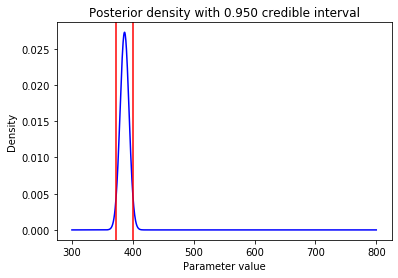

In [215]:
plot_ci(x_1, posterior_1, num_samples, lower_q, upper_q)

## Conclusion

We can finally conclude that there is no overlap between the two distributions. The high end of the one type pokemon distribution is the two type distribution. Our Bayesian sampling exercise also tells us that we can conclude that there is a significant difference between the total attributes of two type vs one type pokemon and it is not likely to be due to random chance.

The implications of this are that two type pokemon are more desirable than one type pokemon. Not just because they are likely to have a more diverse set of moves to find opponent weaknesses, as most people already know, but also because they have higher total attributes on average as well.